# Spiking neural networks for EMG data streaming

In [1]:
import os
import sys
sys.path.append("..")
sys.path.insert(0,"/s2net-emg")

!pip install librosa==0.9.1
!pip install pandas
!pip install numpy==1.21.4
!pip install numba==0.53.0
!pip install scipy
!pip install torch
!pip install torchvision
!pip install matplotlib
import scipy
from scipy import signal
import time
import numpy as np
import librosa
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from torch.utils.data import DataLoader
import torchvision


from utils import plot_spk_rec, plot_mem_rec
from models import SNN, SpikingConv2DLayer, ReadoutLayer, SurrogateHeaviside, SpikingDenseLayer

from data import EMGDataset, PSD, STFT, PSDNoDelta, NoFeatureExtraction, Rescale
from optim import RAdam

  Using cached numpy-1.21.4-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.3
    Uninstalling numpy-1.22.3:
      Successfully uninstalled numpy-1.22.3
  Using cached numba-0.53.0-cp38-cp38-manylinux2014_x86_64.whl (3.4 MB)
  Attempting uninstall: numba
    Found existing installation: numba 0.45.1
    Uninstalling numba-0.45.1:
      Successfully uninstalled numba-0.45.1


In [2]:
# Different feature extraction functions
# 0 - No feature extraction
# 1 - PSD
# 2 - STFT
# 3 - PSDNoDelta
MODE = 1
# Load pretrained model?
LOAD = True

In [3]:
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/magnapinna/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


# Loading Data

In [4]:
train_data_root = "../data/train"
test_data_root = "../data/test"

training_words = os.listdir(train_data_root)
training_words = [x for x in training_words if os.path.isdir(os.path.join(train_data_root,x))]
training_words = [x for x in training_words if os.path.isdir(os.path.join(train_data_root,x)) if x[0] != "_" ]
print("{} training words:".format(len(training_words)))
print(training_words)

10 training words:
['8', '6', '3', '0', '2', '9', '1', '5', '7', '4']


In [5]:
testing_words = os.listdir(test_data_root)
testing_words = [x for x in testing_words if os.path.isdir(os.path.join(train_data_root,x))]
testing_words = [x for x in testing_words if os.path.isdir(os.path.join(train_data_root,x)) 
                 if x[0] != "_"]
print("{} testing words:".format(len(testing_words)))
if len(testing_words) != len(training_words):
    raise ValueError("Mismathed data")
print(testing_words)

10 testing words:
['8', '6', '3', '0', '2', '9', '1', '5', '7', '4']


In [6]:
# Using labels from datasets
label_dct = {'6': 6, '9': 9, '8': 8, '3': 3, '4': 4, '5': 5, '7': 7, '2': 2, '1': 1, '0': 0}
if len(testing_words) != len(label_dct.keys()):
    raise ValueError("Mismathed data")
print("label_dct:")
print(label_dct)

label_dct:
{'6': 6, '9': 9, '8': 8, '3': 3, '4': 4, '5': 5, '7': 7, '2': 2, '1': 1, '0': 0}


In [7]:
sr = 500
size = 500
n_fft = size
hop_length = 20

In [8]:
stft = STFT(n_fft, hop_length)
psd = PSD(sr, n_fft)
psdnodelta = PSDNoDelta(sr, n_fft)
nfe = NoFeatureExtraction()

rescale = Rescale()

if MODE == 0:
    transform = torchvision.transforms.Compose([nfe, rescale])
    in_chan = 1
    in_sh = 8
elif MODE == 1:
    transform = torchvision.transforms.Compose([psd, rescale])
    in_chan = 2
    in_sh = 8
elif MODE == 2:
    transform = torchvision.transforms.Compose([stft, rescale])
    in_chan = 8
    in_sh = 52
elif MODE == 3:
    transform = torchvision.transforms.Compose([psdnodelta, rescale])
    in_chan = 1
    in_sh = 8
else:
    print("Incorect mode, using no transform")
    transform = torchvision.transforms.Compose([nfs, rescale])
    in_chan = 1
    in_sh = 8



def collate_fn(data):
    
    X_batch = np.array([d[0] for d in data])
    std = X_batch.std(axis=(0,3), keepdims=True)
    X_batch = torch.tensor(X_batch/std)
    
    y_batch = torch.tensor([d[1] for d in data])
    
    return X_batch, y_batch 
 

In [9]:
batch_size = 20

train_dataset = EMGDataset(train_data_root, label_dct, transform = transform, mode="train", max_nb_per_class=None)
train_sampler = torch.utils.data.WeightedRandomSampler(train_dataset.weights,len(train_dataset.weights))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, sampler=train_sampler, collate_fn=collate_fn)

valid_dataset = EMGDataset(train_data_root, label_dct, transform = transform, mode="valid", max_nb_per_class=None)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)

test_dataset = EMGDataset(test_data_root, label_dct, transform = transform, mode="test")
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Creating the model

In [10]:
spike_fn = SurrogateHeaviside.apply

w_init_std = 0.15
w_init_mean = 0.

w_init_std = 0.15
w_init_mean = 0.


layers = []
in_channels = in_chan
out_channels = 64
kernel_size = (4,3)
dilation = (1,1)
input_shape = in_sh
output_shape = input_shape # padding mode is "same"
layers.append(SpikingConv2DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
                               lateral_connections=True))

in_channels = out_channels
out_channels = 64
kernel_size = (4,3)
dilation = (4,3)
input_shape = output_shape
output_shape = input_shape # padding mode is "same"
layers.append(SpikingConv2DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
                               lateral_connections=True, flatten_output=True))

# previous layer output has been flattened
input_shape = output_shape*out_channels
output_shape = 10
time_reduction="mean" #mean or max
layers.append(ReadoutLayer(input_shape, output_shape,
                 w_init_mean=w_init_mean, w_init_std=w_init_std, time_reduction=time_reduction))

snn = SNN(layers).to(device, dtype)

X_batch, _ = next(iter(train_dataloader))
X_batch = X_batch.to(device, dtype)
snn(X_batch)

for i,l in enumerate(snn.layers):
    if isinstance(l, SpikingDenseLayer) or isinstance(l, SpikingConv2DLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))

Layer 0: average number of spikes=0.2741
Layer 1: average number of spikes=0.2050


In [11]:
#LOADING MODEL
if LOAD:
    if MODE == 1:
        snn.load_state_dict(torch.load("../saved/modeldictPSD.pt", map_location=device))
    elif MODE == 2:
        snn.load_state_dict(torch.load("../saved/modeldictSTFT.pt", map_location=device))
    elif MODE == 3:
        snn.load_state_dict(torch.load("../saved/modeldictPSDNoDelta.pt", map_location=device))  
    else:
        snn.load_state_dict(torch.load("../saved/modeldictNOFE.pt", map_location=device))


# Training and plotting

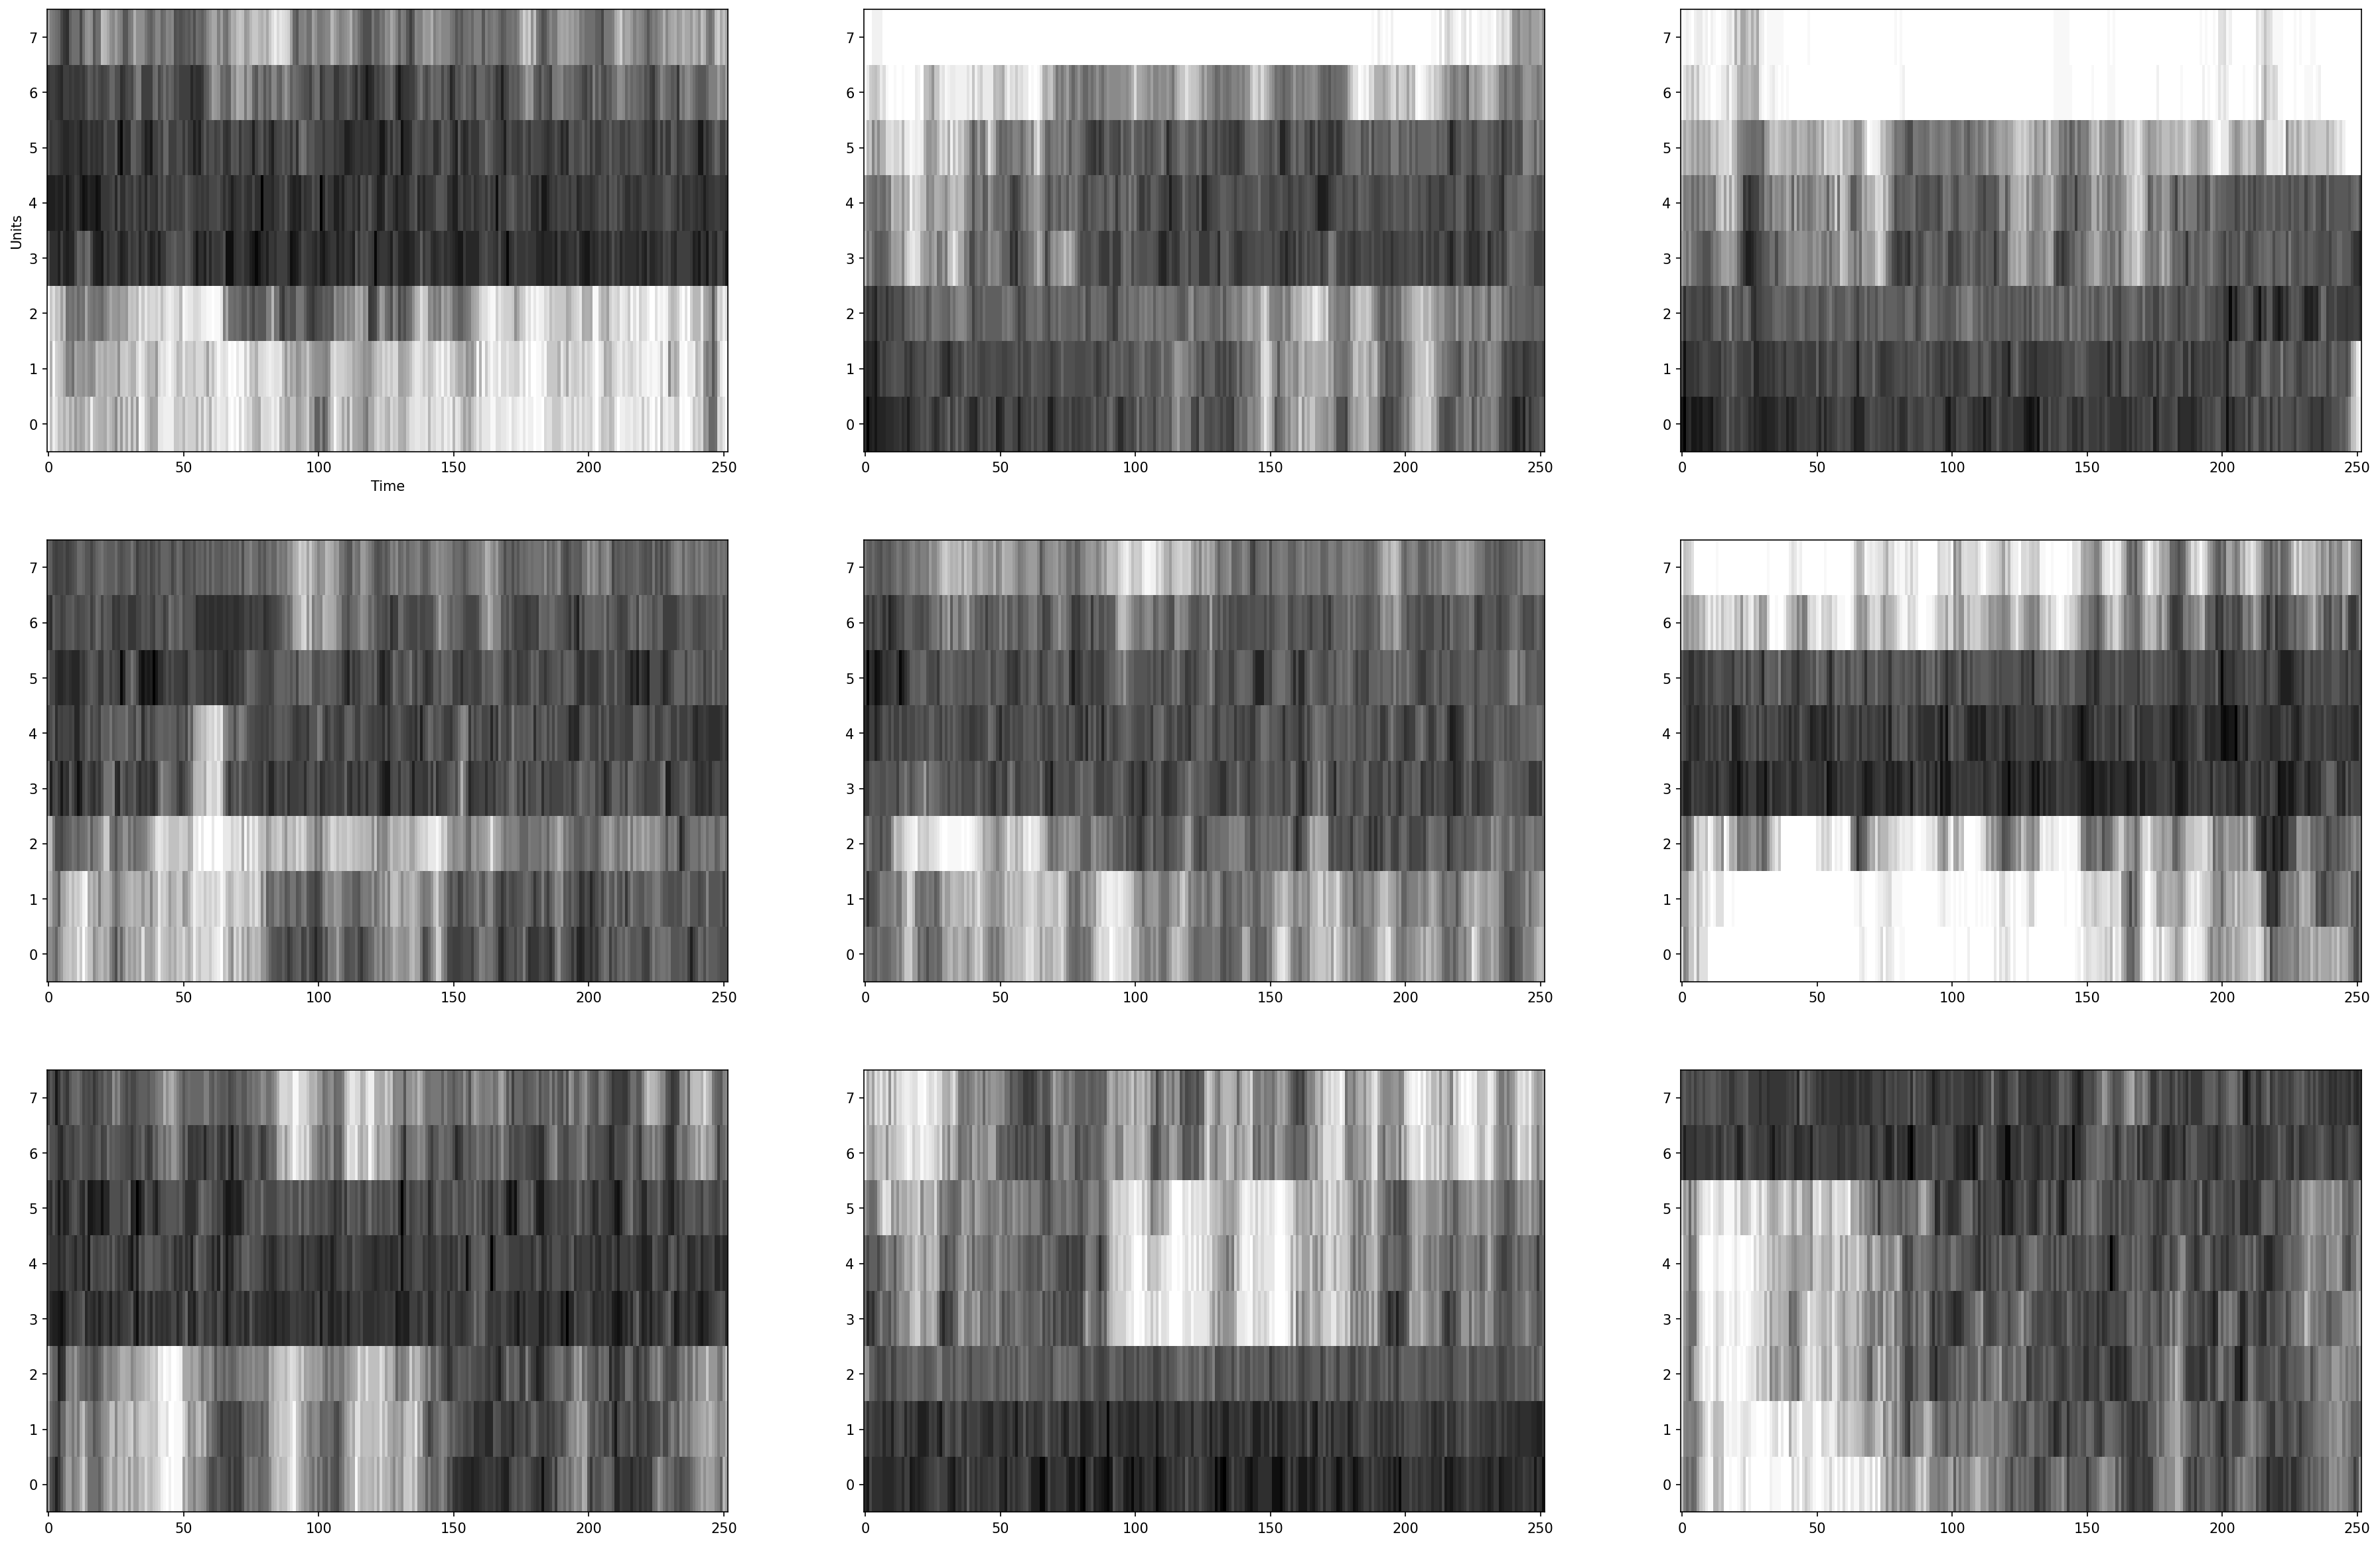

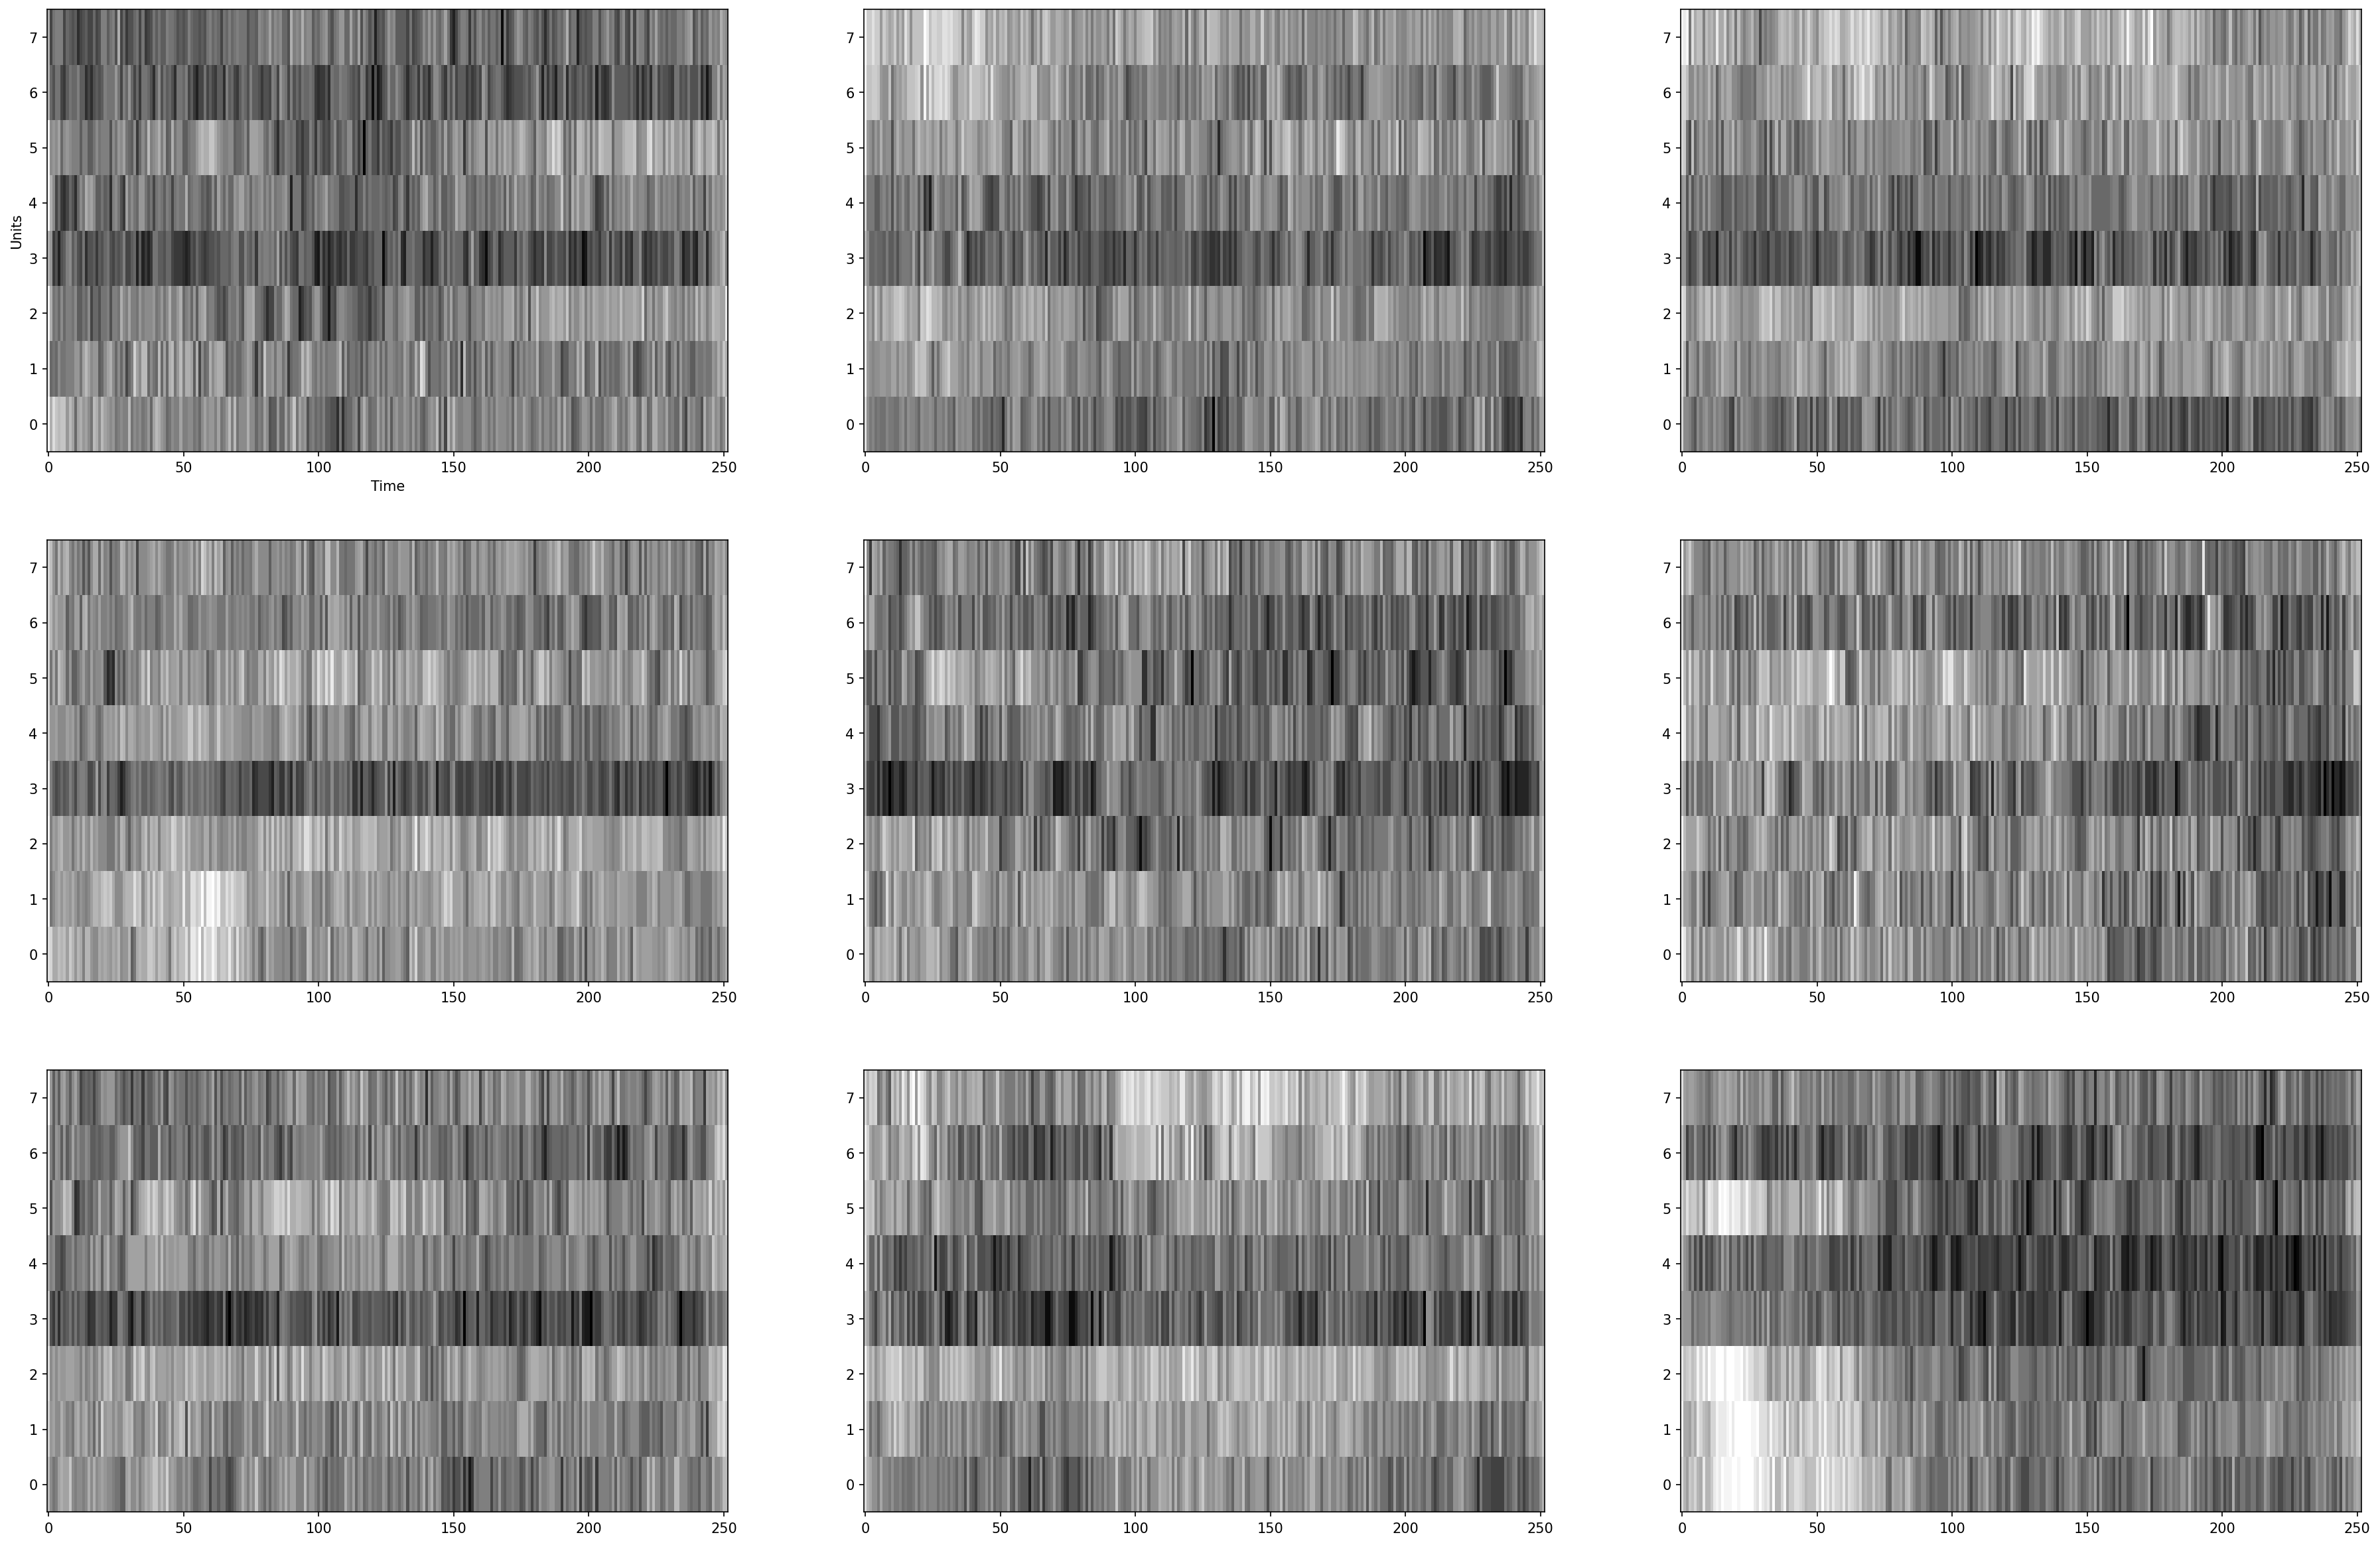

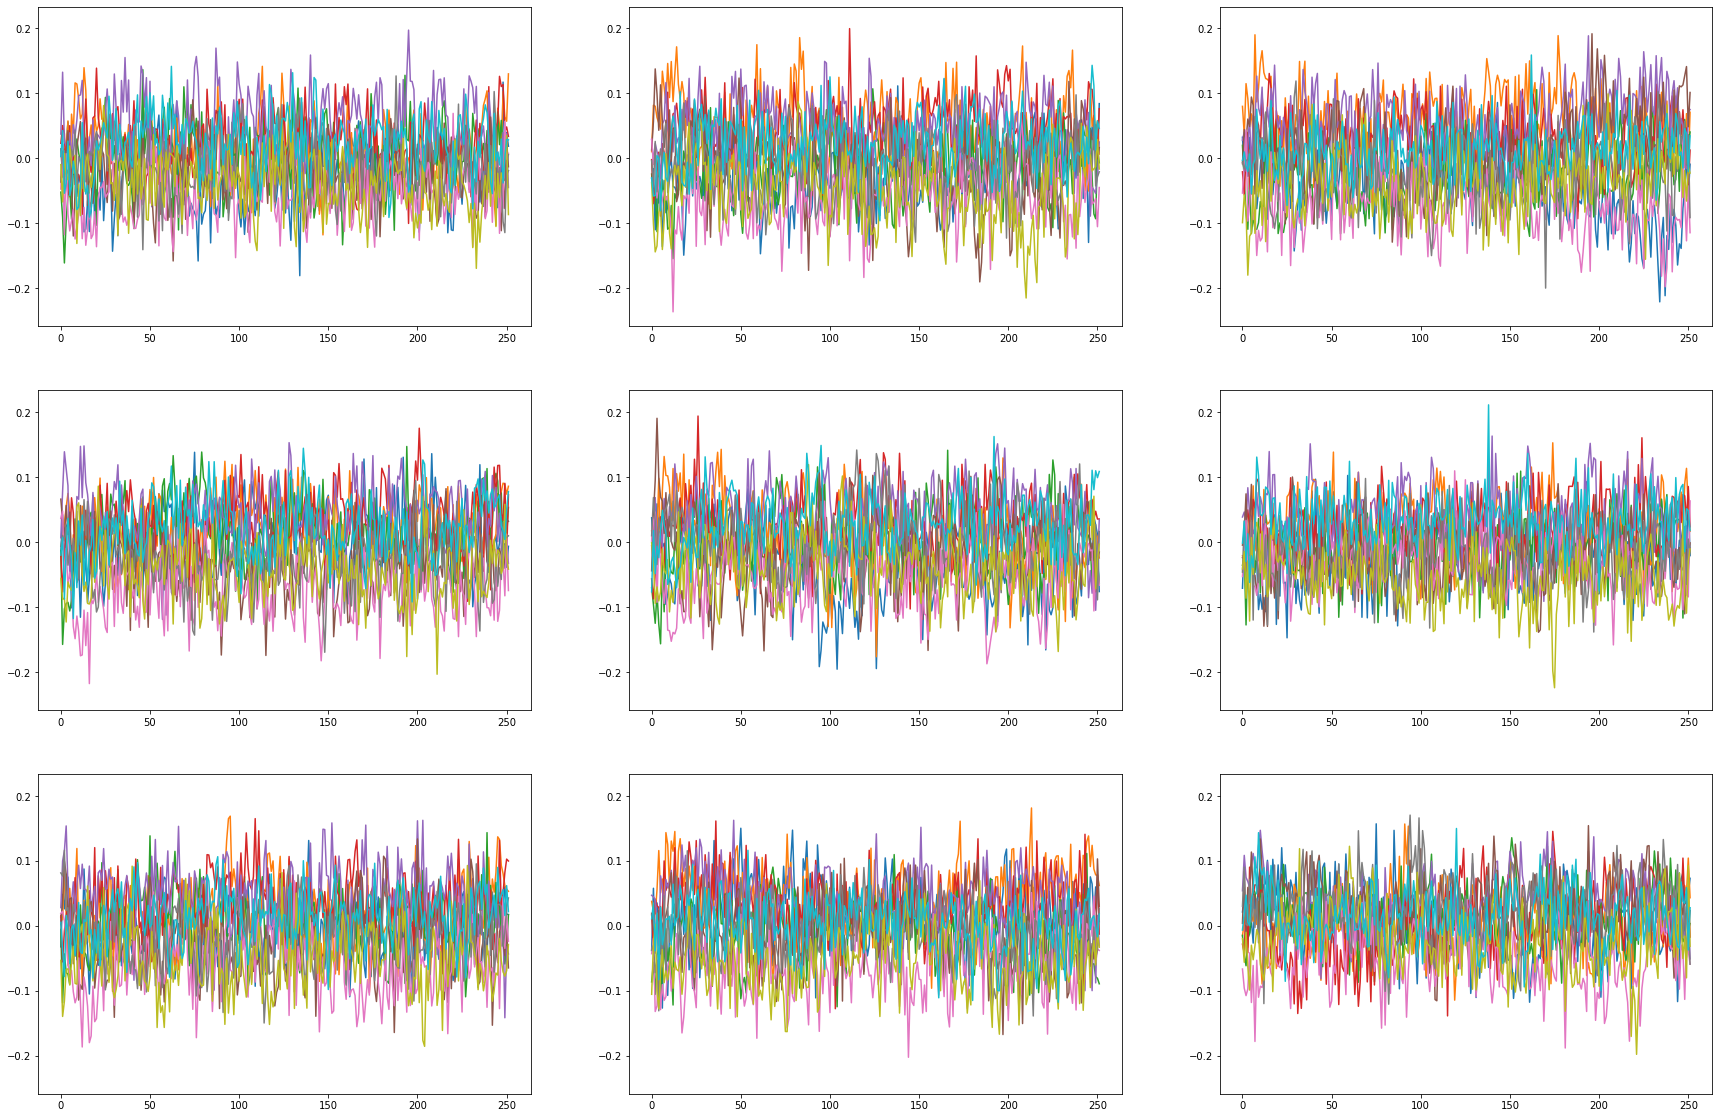

In [12]:
nb_plt = 9

batch_idx = np.random.choice(batch_size, nb_plt, replace=False)

# Plotting spike trains or membrane potential
for i,l in enumerate(snn.layers):
    
    if isinstance(l, SpikingDenseLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx)
    elif isinstance(l, SpikingConv2DLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, batch_idx)

In [13]:
def train(model, params, optimizer, train_dataloader, valid_dataloader, reg_loss_coef, nb_epochs, scheduler=None, warmup_epochs=0):
    
    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()
    
    if warmup_epochs > 0:
        for g in optimizer.param_groups:
            g['lr'] /= len(train_dataloader)*warmup_epochs
        warmup_itr = 1
    
    hist = {'loss':[], 'valid_accuracy':[]}
    for e in range(nb_epochs):
        local_loss = []
        reg_loss = [[] for _ in range(len(model.layers)-1)]
        
        for x_batch, y_batch in train_dataloader:

            x_batch = x_batch.to(device, dtype)
            y_batch = y_batch.to(device)

            output, loss_seq = model(x_batch)
            log_p_y = log_softmax_fn(output)
            loss_val = loss_fn(log_p_y, y_batch)
            local_loss.append(loss_val.item())

            for i,loss in enumerate(loss_seq[:-1]):
                reg_loss_val = reg_loss_coef*loss*(i+1)/len(loss_seq[:-1])
                loss_val += reg_loss_val
                reg_loss[i].append(reg_loss_val.item())


            optimizer.zero_grad()
            loss_val.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), 5)
            optimizer.step()
            model.clamp()

            if e < warmup_epochs:
                for g in optimizer.param_groups:
                    g['lr'] *= (warmup_itr+1)/(warmup_itr)
                warmup_itr += 1
                
                
        if scheduler is not None and e >= warmup_epochs:
            scheduler.step()
        
        mean_loss = np.mean(local_loss)
        hist['loss'].append(mean_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        
        for i,loss in enumerate(reg_loss):
            mean_reg_loss = np.mean(loss)
            print("Layer %i: reg loss=%.5f"%(i,mean_reg_loss))
            
        for i,l in enumerate(snn.layers[:-1]):
            print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        
        valid_accuracy = compute_classification_accuracy(model, valid_dataloader)
        hist['valid_accuracy'].append(valid_accuracy)
        print("Validation accuracy=%.3f"%(valid_accuracy))
        
    return hist
        
def compute_classification_accuracy(model, dataloader):
    accs = []
    with torch.no_grad():
        for x_batch, y_batch in dataloader:

            x_batch = x_batch.to(device, dtype)
            y_batch = y_batch.to(device)
            output, _ = model(x_batch)
            _,am=torch.max(output,1) # argmax over output units
            tmp = np.mean((y_batch==am).detach().cpu().numpy()) # compare to labels
            accs.append(tmp)
    return np.mean(accs)

In [14]:
if LOAD == False:
    lr = 1e-3
    weight_decay = 1e-4
    reg_loss_coef = 0.1
    nb_epochs = 5

    params = [{'params':l.w, 'lr':lr, "weight_decay":weight_decay } for i,l in enumerate(snn.layers)]
    params += [{'params':l.v, 'lr':lr, "weight_decay":weight_decay} for i,l in enumerate(snn.layers[:-1]) if l.recurrent]
    params += [{'params':l.b, 'lr':lr} for i,l in enumerate(snn.layers)]
    if snn.layers[-1].time_reduction == "mean":
        params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(snn.layers[:-1])]
    elif snn.layers[-1].time_reduction == "max":
        params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(snn.layers)]
    else:
        raise ValueError("Readout time recution should be 'max' or 'mean'")
    
    optimizer = RAdam(params)
 
    gamma = 0.85
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)

    hist = train(snn, params, optimizer, train_dataloader, test_dataloader, reg_loss_coef, nb_epochs=nb_epochs,
                    scheduler=scheduler, warmup_epochs=1)


In [ ]:
test_accuracy = compute_classification_accuracy(snn, test_dataloader)
print("Test accuracy=%.3f"%(test_accuracy))

In [ ]:
snn(X_batch)

# Plotting spike trains or membrane potential
for i,l in enumerate(snn.layers):
    
    if isinstance(l, SpikingDenseLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx)
    elif isinstance(l, SpikingConv2DLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, batch_idx)

# Streaming data test

In [ ]:
from streamload import EMGStream, PSD, STFT, PSDNoDelta, NoFeatureExtraction, Rescale

def compute_classification_accuracy(model, dataloader):
    accs = []
    cnt = 0
    
    with torch.no_grad():
        for x_batch, y_batch in dataloader:

            x_batch = x_batch.to(device, dtype)
            y_batch = y_batch.to(device)
            output, _ = model(x_batch)
            _,am=torch.max(output,1) # argmax over output units
            tmp = np.mean((y_batch==am).detach().cpu().numpy()) # compare to labels
            accs.append(tmp)

            if cnt%20 == 0:
                print("Estimation: ", tmp, "SNN output: ", am.item(), "Label: ", y_batch.item())
                print("Batches estimated: ", cnt)
                print("Avg accuracy: %0.3f"%np.mean(accs))
            cnt+=1

    return np.mean(accs)

fn = "../raw/1_raw_data.txt"
bat_size = 20
buff_size = 500  # a multiple of bat_size

stft = STFT(n_fft, hop_length)
psd = PSD(sr, n_fft)
psdnodelta = PSDNoDelta(sr, n_fft)
nfe = NoFeatureExtraction()

rescale = Rescale()

if MODE == 0:
    transform = torchvision.transforms.Compose([nfe, rescale])
    in_chan = 1
    in_sh = 8
elif MODE == 1:
    transform = torchvision.transforms.Compose([psd, rescale])
    in_chan = 2
    in_sh = 8
elif MODE == 2:
    transform = torchvision.transforms.Compose([stft, rescale])
    in_chan = 8
    in_sh = 52
elif MODE == 3:
    transform = torchvision.transforms.Compose([psdnodelta, rescale])
    in_chan = 1
    in_sh = 8
else:
    print("Incorect mode, using no transform")
    transform = torchvision.transforms.Compose([nfs, rescale])
    in_chan = 1
    in_sh = 8



stream_loader = EMGStream(fn, bat_size, buff_size, transform=transform, shuffle=False)
test_accuracy = compute_classification_accuracy(snn, stream_loader)
print("Test accuracy=%.3f"%(test_accuracy))
